Bit Association
---------------

Experiments in using bitstring distance to store arbitrary associations between objects.

In [1]:
from random import getrandbits, random, randrange
from struct import pack, unpack, calcsize
from math import degrees, factorial, fmod, acos, pi, sqrt
import mpmath as mp
import numpy as np
import sympy
import scipy
import matplotlib.pyplot as plt
from pylab import rcParams

%matplotlib inline

rcParams['figure.figsize'] = 15, 10

/home/sagland/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# Define our default parameters
DIM = 2048 # bits

# How are we going to split this up?
PART_DTYPE = np.uint8
PART_MAX   = np.iinfo(PART_DTYPE).max
PART_BYTES = np.dtype(PART_DTYPE).itemsize
PART_BITS  = PART_BYTES << 3

assert(PART_BITS > 0 and not PART_BITS & (PART_BITS - 1)) # Must be a power of 2
assert(DIM % PART_BITS == 0) # Must divide evenly.

PART_SHIFT = PART_BITS.bit_length() - 1
print PART_DTYPE, PART_MAX, PART_BYTES, PART_BITS, PART_SHIFT

<type 'numpy.uint8'> 255 1 8 3


In [3]:
# In this context, a vector is a bitstring of "dim" dimensions, represented for convenience of as a numpy byte array.
zeros_vec = lambda dim=DIM: np.zeros(dim >> PART_SHIFT, PART_DTYPE)
ones_vec = lambda dim=DIM: np.full(dim >> PART_SHIFT, PART_MAX, PART_DTYPE)
random_vec = lambda dim=DIM: np.fromstring(np.random.bytes(dim >> 3), PART_DTYPE)
random_vecs = lambda n, dim=DIM: np.fromstring(np.random.bytes(n * (dim >> 3)), PART_DTYPE).reshape(n, (dim >> PART_SHIFT))

# def hamdist(p, q):
#     '''Returns the Hamming Distance between two vectors.'''
#     diff = p ^ q
#     dist = np.zeros_like(diff)
#     while np.any(diff):
#         dist += diff > 0
#         diff = diff & (diff - 1)
#     return dist.sum()

# Source: https://www.snip2code.com/Snippet/225598/Popcount-of-a-numpy-array-of-32-bit-inte
# Modified to uint8 instead of uint32 (slightly faster) and using bitwise operators directly.
def popcount(a):
    """
    Computes the popcount (Hamming Weight) of a numpy array of 8-bit integers. The popcount of an integer is the 
    number of set bits in an integer. http://en.wikipedia.org/wiki/Hamming_weight
    
    Parameters:
    -----------
    a: array_like, dtype=uint8, shape=(n,m)
      An array of 8-bit integers. Note that the type is not important as long as the values are smaller than 2**8-1
    
    Returns:
    --------
    popcounts: array_like, dtype=uint32, shape=(n,m)
      An array containing the popcount for each element of a
    """
    a -= (a >> 1) & 0x55
    a = (a & 0x33) + ((a >> 2) & 0x33)
    return ((((a + (a >> 4)) & 0x0F) * 0x01)) & 0xff

def hamdist(p, q):
    '''Returns the Hamming Distance between (a) two vectors, or
    (b) one vector and a list of vectors, or (c) piece-wise two
    lists of vectors. In case (b) and (c) a list of distances will
    be returned.'''
    diff = p ^ q
    return popcount(diff).sum(len(diff.shape) - 1)

def all_hamdists(ps):
    '''Given a list of vectors, calculate the distance between every
    pair and return all of them.'''
    n = ps.shape[0]
    dists = np.zeros(n * n - n, dtype=np.uint64)
    for i in range(1, n):
        dists[(i-1) * n: (i) * n] = hamdist(ps, np.roll(ps, i))
    return dists

def jaccard(p, q):
    '''Returns the Jaccard similarity coefficient of two vectors.
    https://en.wikipedia.org/wiki/Jaccard_index
    '''
    diff = p ^ q
    dim = np.uint64(diff.shape[-1] * PART_BITS)
    dist = popcount(diff).sum(len(diff.shape) - 1)
    i = dim - dist # Size of the intersection of elements
    u = dim + dist
    return i.astype(np.float) / u

In [4]:
NTESTS = 128 # Per dimension
distograms = {}
for dim in [1 << x for x  in range(3, 12 + 1, 1)]:
    dntests = NTESTS * dim
    dists = hamdist(random_vecs(dntests, dim), random_vecs(dntests, dim))
    distograms[dim] = np.bincount(dists.astype(np.int), minlength=dim + 1)

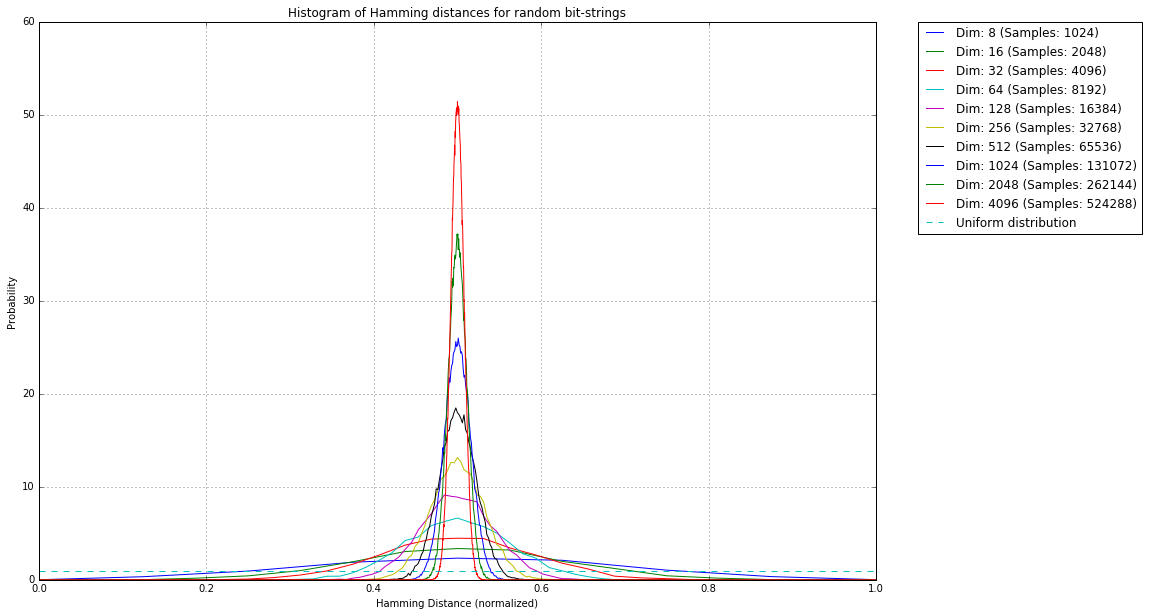

In [5]:
for dim, c in sorted(distograms.iteritems()):
    ntests = float(sum(c))
    plt.plot(np.arange(dim + 1, dtype=np.float) / dim,
             c / (ntests / (dim+1)),
             linewidth=1, label='Dim: %d (Samples: %d)' % (dim, ntests))
plt.plot([0, 1], [1, 1], '--', linewidth=1, label='Uniform distribution')

plt.xlabel('Hamming Distance (normalized)')
plt.ylabel('Probability')
plt.title(r'Histogram of Hamming distances for random bit-strings')
plt.grid(True)
plt.xlim([0, 1])
plt.ylim(ymin=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [6]:
# Cache the results of a few thousand of the first integer factorials.
FACTORIAL_CACHE_SIZE = 2**12 + 2
FACTORIAL_CACHE = [1]
_FACTORIAL_TMP = 1
for x in range(1, FACTORIAL_CACHE_SIZE):
    _FACTORIAL_TMP *= x
    FACTORIAL_CACHE.append(_FACTORIAL_TMP)

In [7]:
def chance_of_k_matches(k, dim):
    global FACTORIAL_CACHE
    numer = FACTORIAL_CACHE[dim]
    denom = FACTORIAL_CACHE[dim - k] * FACTORIAL_CACHE[k] * (1<<dim)
    r = mp.mpf(numer) / denom
    return r

CHANCE_EPS = 1e-10
def chance_of_k_or_fewer_matches(k, dim):
    '''
    http://www.wolframalpha.com/input/?i=sum%28n%21+%2F+%28%28n-k%29%21+*+k%21+*+2%5En%29%2C+k+%3D+0+to+x%29
    '''
    mp.mp.prec = dim * 2
    local_chance = chance_of_k_matches(k, dim)
    if local_chance < CHANCE_EPS: # mp.hyp2f1 get unhappy with low k and ver high dim (> 2048)
        if k < dim / 2:
            return mp.mpf(0.0)
        else:
            return mp.mpf(1.0)
    global FACTORIAL_CACHE
    return 1.0 - ((mp.hyp2f1(1.0, -dim + k + 1, k + 2, -1) * FACTORIAL_CACHE[dim]) /
                  (FACTORIAL_CACHE[k + 1] * FACTORIAL_CACHE[dim - k - 1] * (2**dim)))

In [8]:
probabilities = {}
for dim in [1 << x for x  in range(3, 12 + 1, 1)]:
    probabilities[dim] = np.array([chance_of_k_matches(dist, dim) for dist in range(0, dim + 1)])

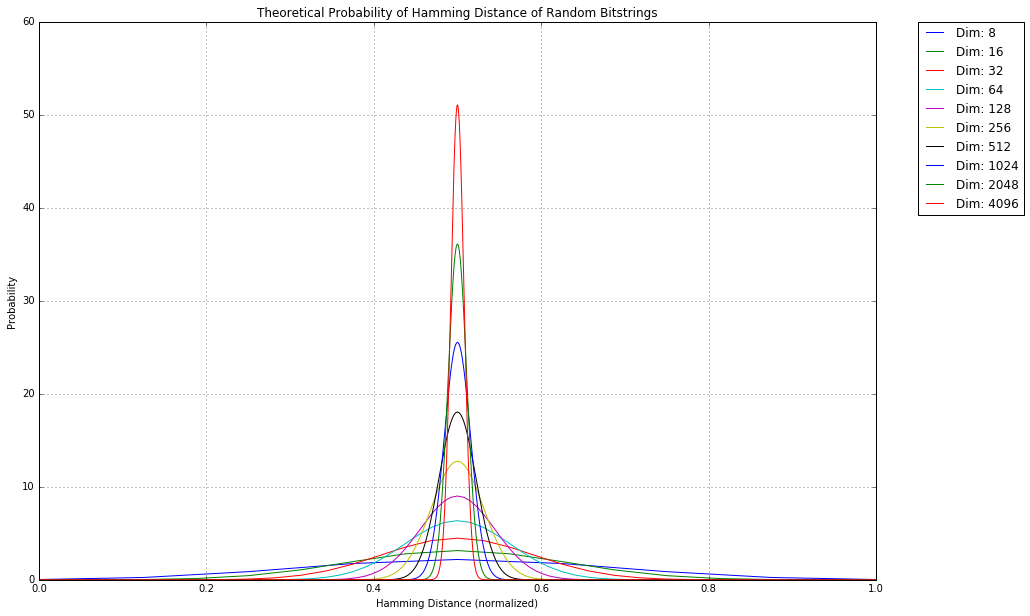

In [9]:
for dim, probs in sorted(probabilities.iteritems()):
    plt.plot(np.arange(dim + 1, dtype=np.float) / dim,
             probs * dim, label='Dim: %d' % dim)
plt.xlabel('Hamming Distance (normalized)')
plt.ylabel('Probability')
plt.title(r'Theoretical Probability of Hamming Distance of Random Bitstrings')
plt.grid(True)
plt.xlim([0, 1])
plt.ylim(ymin=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [10]:

# Define a similarity function based on the probability
# that a uniformly sampled random vector would be closer
# to p than q is.

# Cache the results.
SIMILARITY_CACHE = {}

def similarity(p, q):
    dim = p.shape[-1] * PART_BITS
    global SIMILARITY_CACHE
    try:
        similarity_lut = SIMILARITY_CACHE[dim]
    except KeyError:
        ckof = np.fromiter((float(chance_of_k_or_fewer_matches(k, dim)) for k in range(dim + 1)), np.float32)
        ck = ckof.copy()
        ck[1:] = ckof[1:] - ckof[0:-1]
        dimratio = np.fromiter((k / float(dim) for k in range(dim + 1)), np.float32)
        hdprob = ckof - ck * (1.0 - dimratio)
        similarity_lut = 1.0 - hdprob 
        SIMILARITY_CACHE[dim] = similarity_lut
    return similarity_lut[hamdist(p, q)]

65536


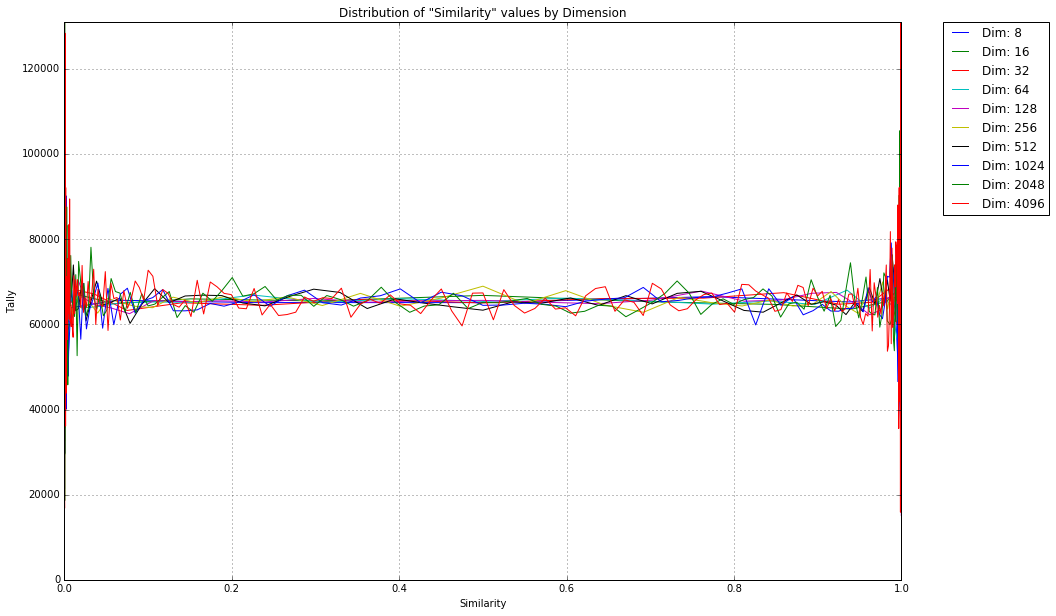

In [11]:
# Test the similarity function to ensure results are uniform
NTESTS = 4096*16
print NTESTS
for x  in range(3, 12 + 1, 1):
    dim = 1 << x
    simhist = {}
    for sim in similarity(random_vecs(NTESTS, dim), random_vecs(NTESTS, dim)):
        try:
            simhist[sim] += 1
        except KeyError:
            simhist[sim] = 1
    items = sorted(simhist.iteritems())
    sims = np.array([s for s, c in items])
    spans = np.zeros(len(sims))
    # We want to check that the number of similarity hits is
    # is uniform over a space of similarity range.
    spans[1:-1] = ((sims[1:-1] - sims[0:-2]) + (sims[2:] - sims[1:-1])) / 2.0
    spans[0] = sims[1] - sims[0]
    spans[-1] = sims[-1] - sims[-2]
    tally = np.array([c for s, c in items])
    plt.plot(sims, tally / spans, label="Dim: %d" % dim)
plt.xlabel('Similarity')
plt.ylabel('Tally')
plt.title(r'Distribution of "Similarity" values by Dimension')
plt.grid(True)
plt.ylim(0, NTESTS * 2)
plt.xlim([0, 1])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [12]:
# Given a list of vectors, returns a vector which is the "average" of all of them.
# Count the occurances of each bit, if more than half are 1, the result is 1 for that bit.
def avg_vector(vecs, weights=None):
    # Weights must be an array of ints the same length as vecs, or None.
    assert(weights is None or len(weights) == len(vecs))
    assert(PART_BITS == 8)
    n = vecs.shape[0]
    t = n if weights is None else abs(weights).sum()
    h = t / 2
    dim = vecs.shape[1] * PART_BITS
    bittally = np.unpackbits(vecs).astype(np.uint64).reshape(n, dim)
    if weights is not None:
        negweights = weights < 0
        if any(negweights):
            bittally[negweights] ^= 1 
        bittally *=  abs(weights).astype(np.uint64).reshape((n, 1))
    bittally = bittally.sum(0)
    # If there's an even number, some bits may tally exactly half.
    # Sprinkle random values on top to randomly (unbiasedly) drop
    # the fence-sitters on one side of the other.
    if t % 1 == 0: # even
        bittally += np.unpackbits(random_vec(dim))
    return np.packbits((bittally > h).astype(np.uint8))

In [13]:
# Given a list of vectors, returns a vector which is the "average" of all of them.
# Alternative implementation stochastically samples a value for each bit, using
# the weighted average as a probability.
def avg_vector2(vecs, weights=None):
    # Weights must be an array of uints the same length as vecs, or None.
    assert(PART_BITS == 8)
    n = vecs.shape[0]
    t = n if weights is None else weights.sum()
    dim = vecs.shape[1] * PART_BITS
    bittally = np.unpackbits(vecs).astype(np.uint64).reshape(n, dim)
    if weights is not None:
        bittally *=  weights.astype(np.uint64).reshape((n, 1))
    bittally = bittally.sum(0)
    samples = np.random.randint(0, t, dim)
    return np.packbits((bittally > samples).astype(np.uint8))

In [14]:
NVECS  = 128
NTESTS = 32
distograms2 = {}
for dim in [1 << x for x  in range(3, 12 + 1, 1)]:
    ntests = NTESTS * dim / NVECS
    print 'dim:', dim, ' | ntests:', ntests
    distograms2[dim] = np.zeros(dim + 1)
    for x in range(max(1, ntests)):
        vecs  = random_vecs(NVECS, dim)
        avg   = avg_vector(vecs)
        dists = hamdist(avg, vecs)
        distograms2[dim] += np.bincount(dists.astype(np.int), minlength=dim + 1)

dim: 8  | ntests: 2
dim: 16  | ntests: 4
dim: 32  | ntests: 8
dim: 64  | ntests: 16
dim: 128  | ntests: 32
dim: 256  | ntests: 64
dim: 512  | ntests: 128
dim: 1024  | ntests: 256
dim: 2048  | ntests: 512
dim: 4096  | ntests: 1024


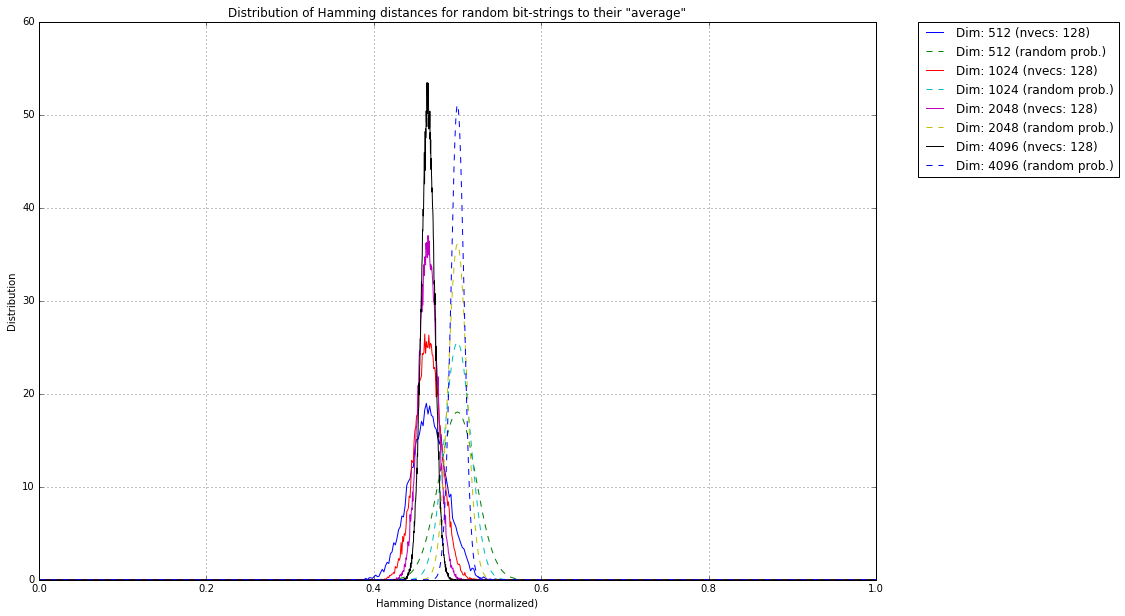

In [15]:
for dim, c in sorted(distograms2.iteritems()):
    if dim < 512:
        continue
    probs = probabilities[dim]
    ntests = float(sum(c))
    plt.plot(np.arange(dim + 1, dtype=np.float) / dim,
             c / (ntests / (dim+1)),
             linewidth=1, label='Dim: %d (nvecs: %d)' % (dim, NVECS))
    plt.plot(np.arange(dim + 1, dtype=np.float) / dim,
             probs * dim, '--',
             linewidth=1, label='Dim: %d (random prob.)' % dim)
#plt.plot([0, 1], [1, 1], '--', linewidth=1, label='Uniform distribution')

plt.xlabel('Hamming Distance (normalized)')
plt.ylabel('Distribution')
plt.title(r'Distribution of Hamming distances for random bit-strings to their "average"')
plt.grid(True)
plt.xlim([0, 1])
plt.ylim(ymin=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

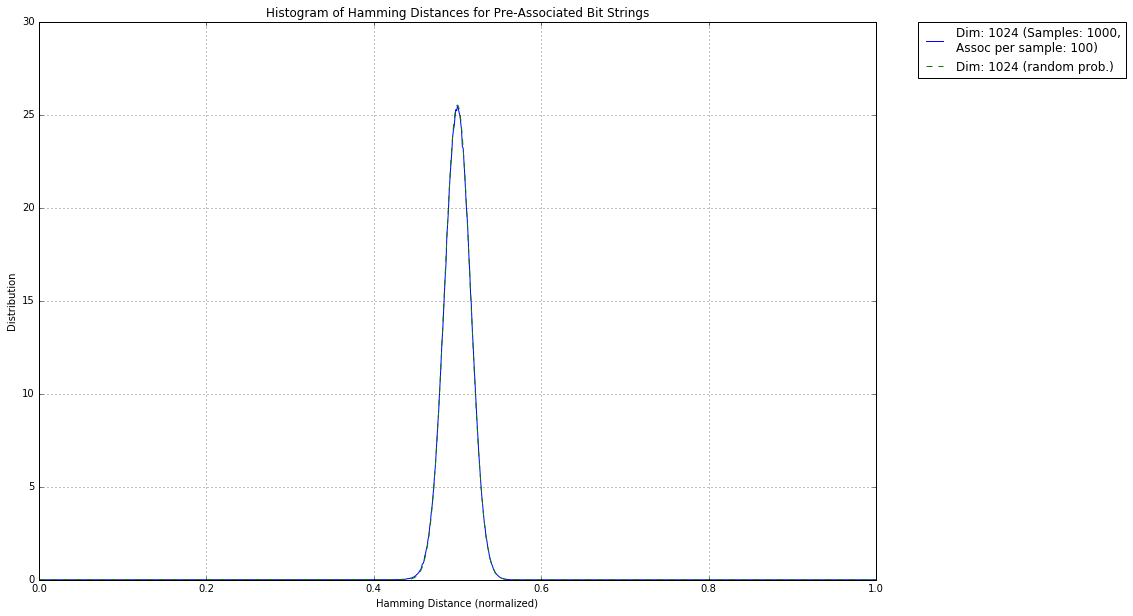

In [16]:
# Lets test if averaging vectors (i.e. finding the point closest to all vectors) can bias a set
# of random vectors such that "diversity" is lost. This is a concern with this approach.
DIM = 1024
NSAMPLES = 1000 # Number of points
NRELATIONS = 100 # Each point will randomly this many relations

vecs = random_vecs(NSAMPLES, DIM)

# Make new vectors, each an average of a random set of relations
newvecs = vecs.copy()
for n in range(NSAMPLES):
    ids = np.random.randint(0, NSAMPLES, NRELATIONS)
    newvecs[n] = avg_vector(vecs[ids])
    
# # Now, is there a bias in the resulting vectors?
dists = all_hamdists(newvecs)
distograms3 = np.bincount(dists.astype(np.int), minlength=DIM + 1)

ntests = float(sum(distograms3))
plt.plot(np.arange(DIM + 1, dtype=np.float) / DIM,
         distograms3 / (ntests / (DIM+1)),
         linewidth=1, label='Dim: %d (Samples: %d,\nAssoc per sample: %d)' % (DIM, NSAMPLES, NRELATIONS))
plt.plot(np.arange(DIM + 1, dtype=np.float) / DIM,
         probabilities[DIM] * DIM, '--',
         linewidth=1, label='Dim: %d (random prob.)' % DIM)
plt.xlabel('Hamming Distance (normalized)')
plt.ylabel('Distribution')
plt.title(r'Histogram of Hamming Distances for Pre-Associated Bit Strings')
plt.grid(True)
plt.xlim([0, 1])
plt.ylim(ymin=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

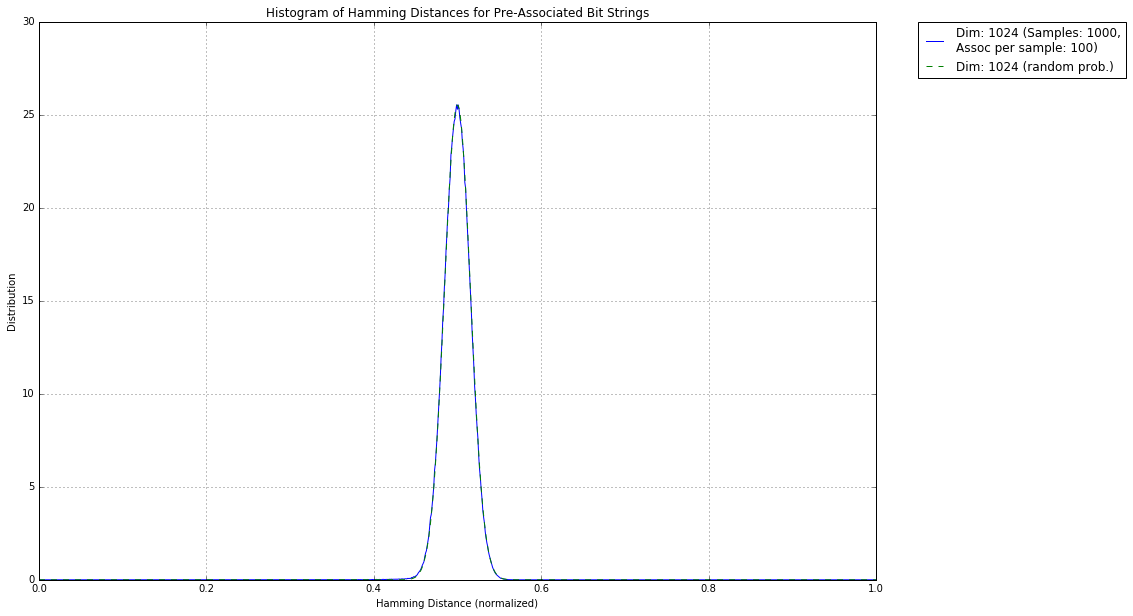

In [17]:
# Let's try that test again, but this time give the vectos different weights, so
# that some will dominate. Let's see what sort of a bias that generates.
DIM = 1024
NSAMPLES = 1000 # Number of points
NRELATIONS = 100 # Each point will randomly this many relations

vecs = random_vecs(NSAMPLES, DIM)
weights = 1 << np.random.randint(0, 20, NSAMPLES).astype(np.uint64)
#weights = np.zeros(NSAMPLES, dtype=np.uint64)
#weights[0] = 10001

# Make new vectors, each an average of a random set of relations
newvecs = vecs.copy()
for n in range(NSAMPLES):
    ids = np.random.randint(0, NSAMPLES, NRELATIONS)
    newvecs[n] = avg_vector(vecs[ids], weights[ids])
    
# # Now, is there a bias in the resulting vectors?
dists = all_hamdists(newvecs)
distograms3 = np.bincount(dists.astype(np.int), minlength=DIM + 1)

ntests = float(sum(distograms3))
plt.plot(np.arange(DIM + 1, dtype=np.float) / DIM,
         distograms3 / (ntests / (DIM+1)),
         linewidth=1, label='Dim: %d (Samples: %d,\nAssoc per sample: %d)' % (DIM, NSAMPLES, NRELATIONS))
plt.plot(np.arange(DIM + 1, dtype=np.float) / DIM,
         probabilities[DIM] * DIM, '--',
         linewidth=1, label='Dim: %d (random prob.)' % DIM)
plt.xlabel('Hamming Distance (normalized)')
plt.ylabel('Distribution')
plt.title(r'Histogram of Hamming Distances for Pre-Associated Bit Strings')
plt.grid(True)
plt.xlim([0, 1])
plt.ylim(ymin=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

[-128 -127 -126 -125 -124 -123 -122 -121 -120 -119 -118 -117 -116 -115 -114
 -113 -112 -111 -110 -109 -108 -107 -106 -105 -104 -103 -102 -101 -100  -99
  -98  -97  -96  -95  -94  -93  -92  -91  -90  -89  -88  -87  -86  -85  -84
  -83  -82  -81  -80  -79  -78  -77  -76  -75  -74  -73  -72  -71  -70  -69
  -68  -67  -66  -65  -64  -63  -62  -61  -60  -59  -58  -57  -56  -55  -54
  -53  -52  -51  -50  -49  -48  -47  -46  -45  -44  -43  -42  -41  -40  -39
  -38  -37  -36  -35  -34  -33  -32  -31  -30  -29  -28  -27  -26  -25  -24
  -23  -22  -21  -20  -19  -18  -17  -16  -15  -14  -13  -12  -11  -10   -9
   -8   -7   -6   -5   -4   -3   -2   -1    0    1    2    3    4    5    6
    7    8    9   10   11   12   13   14   15   16   17   18   19   20   21
   22   23   24   25   26   27   28   29   30   31   32   33   34   35   36
   37   38   39   40   41   42   43   44   45   46   47   48   49   50   51
   52   53   54   55   56   57   58   59   60   61   62   63   64   65   66
   67   68  

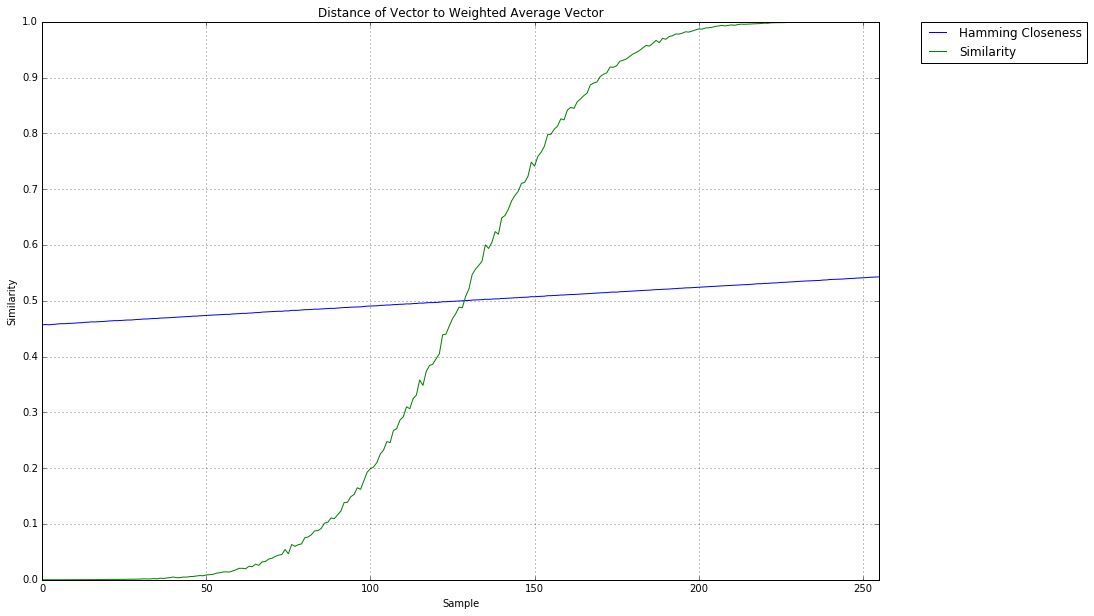

In [18]:
# Okay, I'm confused. No bias at all? I've broken something. I'mm try something else...
# Generate some vectors, give each an incrementally highter weight, get a weighted 
# average vector, then check that those with higher weights tend to have a shorter
# distance to the weighted vector.
NSAMPLES = 256
DIM = 4096
NTESTS = 2048

dists = np.zeros((NTESTS, NSAMPLES), dtype=np.uint32)
sims = np.zeros((NTESTS, NSAMPLES), dtype=np.float32)
#weights = (np.arange(NSAMPLES, dtype=np.int64) - (NSAMPLES / 2))
weights = np.arange(NSAMPLES, dtype=np.int64) - NSAMPLES / 2
#weights = (((np.arange(NSAMPLES, dtype=np.float32) / (NSAMPLES-1)) ** 2) * NSAMPLES**2).astype(np.int64)
#weights=None
print weights
for n in range(NTESTS):
    vecs = random_vecs(NSAMPLES, DIM)
    avgvec = avg_vector(vecs, weights)
    dists[n] = hamdist(vecs, avgvec)
    sims[n] = similarity(vecs, avgvec)
dists = dists.mean(0)
sims = sims.mean(0)

# from scipy.optimize import curve_fit
# popt, pcov = curve_fit(lambda x, l, c: l*x + c,
#                        weights, 1 - dists / np.float(DIM))
# print 'Slope:', popt[0]
# print '0-point:', popt[1] * DIM

plt.plot(np.arange(NSAMPLES), 1 - dists / np.float(DIM), linewidth=1, label='Hamming Closeness')
plt.plot(np.arange(NSAMPLES), sims, linewidth=1, label='Similarity')
plt.xlabel('Sample')
plt.ylabel('Similarity')
plt.title(r'Distance of Vector to Weighted Average Vector')
plt.grid(True)
plt.xlim([0, NSAMPLES - 1])
plt.ylim([0, 1])
plt.yticks(np.arange(10 + 1) / 10.0)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [19]:
def random_similarily_test(n, dim):
    '''Generates n random vectors of dimension dim, calculates
    their "average" vector, then returns the mean similarity
    between that vector and each of the original vectors.
    This is a measure of how much "memory" the average vector
    retains of its inputs.'''
    vecs = random_vecs(n, dim)
    avg = avg_vector(vecs)
    return similarity(avg, vecs).mean()

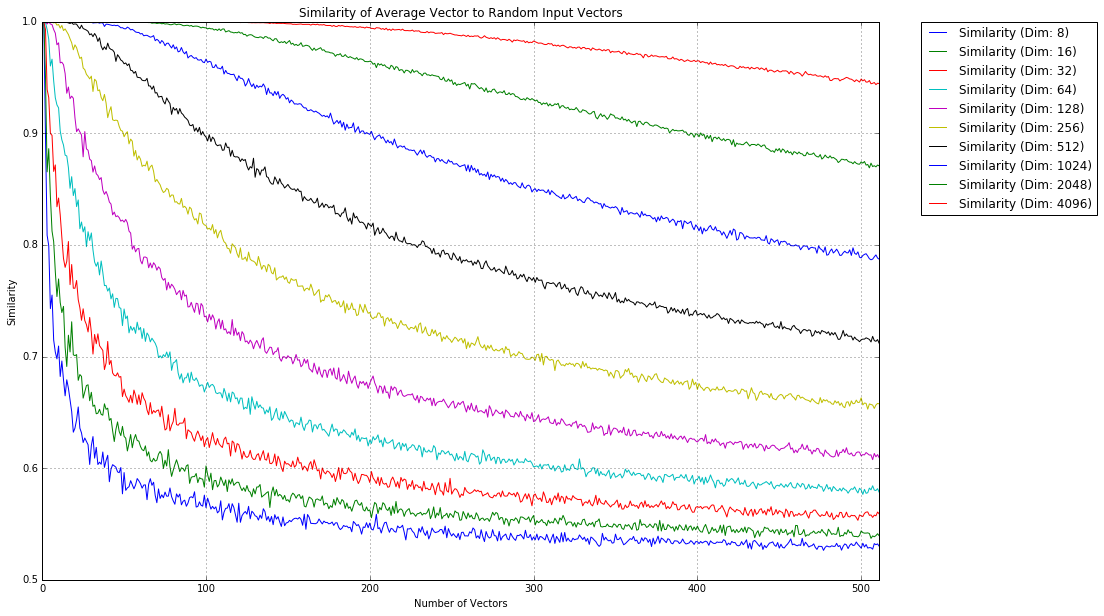

In [20]:
    # Check how the similarity drops off as you evenly "average"
    # more and more random vectors.
    NSAMPLES = 512
    NTESTS = 16

    for e in range(3, 12 + 1, 1):
        DIM = 1 << e
        sims = np.ones((NTESTS, NSAMPLES + 1), dtype=np.float32)
        for t in range(NTESTS):
            for n in range(2, NSAMPLES + 1):
                sims[t,n] = random_similarily_test(n, DIM)
        plt.plot(np.arange(NSAMPLES + 1), sims.mean(0), linewidth=1, label='Similarity (Dim: %d)' % DIM)

    plt.xlabel('Number of Vectors')
    plt.ylabel('Similarity')
    plt.title(r'Similarity of Average Vector to Random Input Vectors')
    plt.grid(True)
    plt.xlim([0, NSAMPLES - 1])
    plt.ylim([0.5, 1])
    plt.yticks(np.arange(5, 10 + 1) / 10.0)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    plt.show()

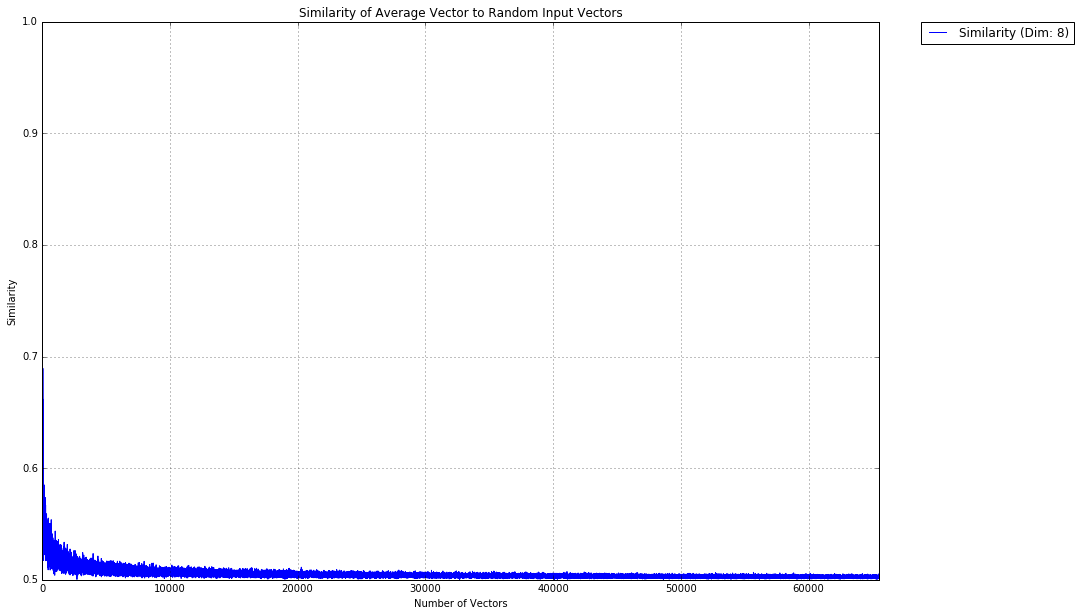

In [21]:
    # Check how the similarity drops off as you evenly "average"
    # more and more random vectors.
    NSAMPLES = 2**16
    NTESTS = 1

    for e in range(3, 4, 1):
        DIM = 1 << e
        sims = np.ones((NTESTS, NSAMPLES + 1), dtype=np.float32)
        for t in range(NTESTS):
            for n in range(2, NSAMPLES + 1):
                sims[t,n] = random_similarily_test(n, DIM)
        plt.plot(np.arange(NSAMPLES + 1), sims.mean(0), linewidth=1, label='Similarity (Dim: %d)' % DIM)

    plt.xlabel('Number of Vectors')
    plt.ylabel('Similarity')
    plt.title(r'Similarity of Average Vector to Random Input Vectors')
    plt.grid(True)
    plt.xlim([0, NSAMPLES - 1])
    plt.ylim([0.5, 1])
    plt.yticks(np.arange(5, 10 + 1) / 10.0)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    plt.show()

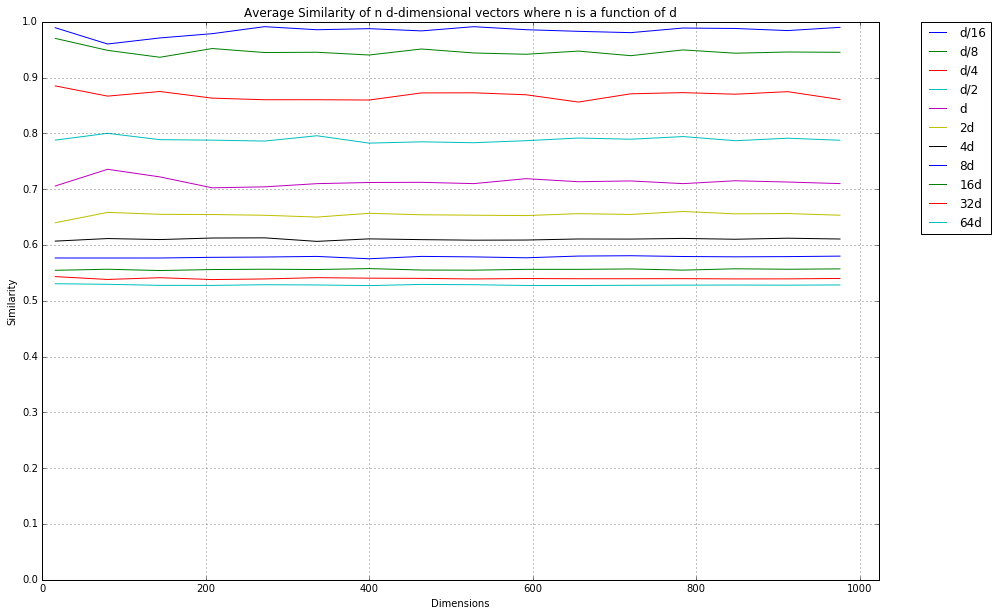

In [22]:
# Check what the average similarity is for an average vector
# when the number of averaged vectors == the dimension. How
# does this change as dimensionality increases?
NTESTS = 4

fs = [
    ('d/16',   lambda d: d/16.0),
    ('d/8',    lambda d: d/8.0),
    ('d/4',    lambda d: d/4.0),
    ('d/2',    lambda d: d/2.0),
    ('d',      lambda d: d),
    ('2d',     lambda d: 2*d),
    ('4d',     lambda d: 4*d),
    ('8d',     lambda d: 8*d),
    ('16d',    lambda d: 16*d),
    ('32d',    lambda d: 32*d),
    ('64d',    lambda d: 64*d),
]

for l, f in fs:
    rs = []
    for o in range(2, (1024/8) + 1, 8):
        dim = 8 * o
        n = int(round(f(dim)))
        rs.append((dim, np.array([random_similarily_test(n, dim) for i in range(NTESTS)]).mean()))
    plt.plot([n for n,s in rs], [s for n,s in rs], label=l)

plt.xlabel('Dimensions')
plt.ylabel('Similarity')
plt.title(r'Average Similarity of n d-dimensional vectors where n is a function of d')
plt.grid(True)
plt.xlim([0, 1024])
plt.ylim([0.5, 1])
plt.yticks(np.arange(10 + 1) / 10.0)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

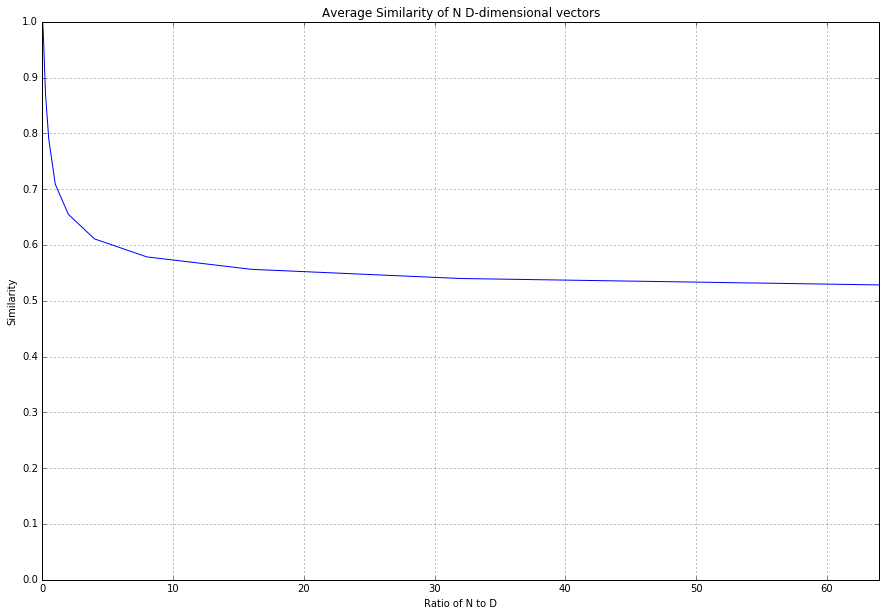

In [23]:
# So it seems like the similarity of N averaged N-dimensional vectors is
# constant as N varies - Interesting. Let's see how the ratio of vectors
# to the dimension changes. In future it would be nice to compare this
# to alternative representations (hyper-spherical float vectors etc.)
NTESTS = 8

maxratio = 0

simd = {}
for er in range(7):
    ratio = 1 << er
    iratio = 1.0 / ratio
    # We'll try the ratio of nvecs:dim, AND dim:nvecs
    sims = []
    isims = []
    for e in range(7, 11):
        dim = 1 << e
        nvec = dim * ratio
        sims.extend(random_similarily_test(nvec, dim) for n in range(NTESTS))
        invec = dim * iratio
        if invec >= 1:
            invec = int(round(invec))
            isims.append(random_similarily_test(invec, dim))
    simd[ratio] = np.array(sims).mean()
    simd[iratio] = np.array(isims).mean()
    maxratio = max(maxratio, ratio)

siml = sorted(simd.iteritems())
plt.plot([r for r,s in siml], [s for r,s in siml])

plt.xlabel('Ratio of N to D')
plt.ylabel('Similarity')
plt.title(r'Average Similarity of N D-dimensional vectors')
plt.grid(True)
plt.xlim([0, maxratio])
plt.ylim([0.5, 1])
plt.yticks(np.arange(10 + 1) / 10.0)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [24]:
# Okay, next test!
# Let's generate a test data set, with random relationships, and see how
# well we can preserve a trace of those relationships. Are there different
# methods for altering the vectors of each entity that are more
# preserving?
DIM            = 1024
NENTITIES      = 1024
NRELATIONSHIPS = 4096
WEIGHTRANGE    = (1, 10)

# Initialize entities vectors randomly.
vecs = random_vecs(NENTITIES, DIM)

# Generate a number of relationships between entities
rels = np.random.randint(NENTITIES, size=NRELATIONSHIPS * 3).reshape(NRELATIONSHIPS, 3)

# Each relationship has a weight in the third column
rels[:,2] = np.random.random_integers(WEIGHTRANGE[0], WEIGHTRANGE[1], size=NRELATIONSHIPS)

#import pandas as pd
#reldf = pd.DataFrame(rels, columns=['a','b','w'])
#pd.DataFrame(vecs)

rels = rels[rels[:,0].argsort()] # Sort by the first column (the first entity index)
similarity(vecs[rels[:,0]], vecs[rels[:,1]]).mean()

/home/sagland/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:18: DeprecationWarning: This function is deprecated. Please call randint(1, 10 + 1) instead


0.50256062

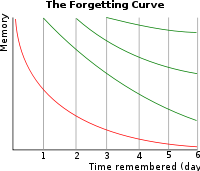

In [25]:
from IPython.display import Image
Image('http://www.creativityandlanguages.com/wp-content/uploads/2011/06/200px-ForgettingCurve.svg_.png')